## Imports

In [1]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dataset.dataset import MultiModalDataset
from mmcv_model.mmcv_csn import ResNet3dCSN
from mmcv_model.scheduler import GradualWarmupScheduler

from model.multimodal_neck import MultiModalNeck
from model.simple_head import SimpleHead
from model.flow_autoencoder import FlowAutoencoder

/home/myuser1/miniconda3/envs/wlasl/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
device='cuda'

## Dataloader

In [3]:
test_dataset = MultiModalDataset(ann_file='../../../data/wlasl/test_annotations.txt',
                                 root_dir='../../../data/wlasl/rawframes',
                                 clip_len=32,
                                 resolution=224,
                                 modalities=('rgb'),
                                 test_mode=True,
                                 frame_interval=1,
                                 input_resolution=256,
                                 num_clips=1
                                 )


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=4,
                                          pin_memory=True)

## Loading the model

In [4]:
# Custom multimodal model
rgb_backbone = ResNet3dCSN(
    pretrained2d=False,
    pretrained=None,
#     pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)


neck = MultiModalNeck()

head = SimpleHead(num_classes=400,
                  in_channels=2048,
                  dropout_ratio=0.5,
                  init_std=0.01)


model = FlowAutoencoder(rgb_backbone=rgb_backbone,
                        neck=neck,
                        head=head)

checkpoint = torch.load('flow_encoder_rgb_wlasl100_100e.pth')
model.load_state_dict(checkpoint)
model.to(device)

FlowAutoencoder(
  (rgb_backbone): ResNet3dCSN(
    (conv1): ConvModule(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
    (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (pool2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): CSNBottleneck3d(
        (conv1): ConvModule(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (activate): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): ConvModule(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=

In [119]:
def imshow(tensor, idx=0):
    plt.imshow(tensor.permute(1, 2, 3, 0)[idx])
    plt.axis('off')

## Evaluation

In [120]:
# Calculate accuracy
df = pd.DataFrame(columns=['class_id', 'prediction_id'])

for i, batch in enumerate(test_loader):
    model.eval()

    with torch.inference_mode():
        cls_score = model(batch['rgb'].to(device))

    df.loc[len(df)+1] = (batch['label'].item(), cls_score.argmax().item())

In [121]:
class_list = dict()
with open('../wlasl_class_list.txt', 'r') as fin:
    line = fin.readline()
    while line:
        values = line.split()
        class_list[values[0]] = values[1]
        line = fin.readline() 

In [122]:
df['gloss'] = df.apply(lambda x: class_list[str(x['class_id'])], axis=1)
df['prediction'] = df.apply(lambda x: class_list[str(x['prediction_id'])], axis=1)
df['correct'] = df['class_id'] == df['prediction_id']

In [123]:
df.head()

class_id  prediction_id  gloss prediction  correct
1        86             86    how        how     True
2        46              6  shirt    clothes    False
3        38             38   fish       fish     True
4        19             19  black      black     True
5        55             55  color      color     True

In [74]:
df['gloss'].unique()

array(['purple', 'cow', 'black', 'before', 'decide', 'forget', 'mother',
       'bed', 'cook', 'graduate', 'full', 'corn', 'like', 'help', 'candy',
       'cool', 'need', 'can', 'pizza', 'same', 'pink', 'last', 'computer',
       'bird', 'what', 'how', 'orange', 'meet', 'doctor', 'basketball',
       'time', 'go', 'who', 'chair', 'city', 'shirt', 'play', 'hot',
       'but', 'clothes', 'drink', 'letter', 'hearing', 'cousin',
       'medicine', 'want', 'apple', 'cheat', 'fish', 'blue', 'man',
       'fine', 'accident', 'birthday', 'white', 'school', 'language',
       'year', 'right', 'secretary', 'dark', 'thin', 'change', 'walk',
       'dance', 'all', 'book', 'tall', 'no', 'woman', 'table', 'kiss',
       'yes', 'color', 'deaf', 'enjoy', 'work', 'wrong', 'study', 'now',
       'paint', 'short', 'paper', 'eat', 'africa', 'give', 'tell',
       'jacket', 'finish', 'son', 'bowling', 'dog', 'thanksgiving',
       'pull', 'brown', 'later', 'family', 'many', 'hat', 'thursday'],
      dtype=

In [124]:
len(df[df['correct']==True])/len(test_loader)

0.810077519379845

In [125]:
df_confusion = pd.crosstab(df['gloss'], df['prediction'])

In [83]:
x = list(df['prediction'].unique())

In [84]:
y = list(df['gloss'].unique())

In [85]:
for value in y:
    if value in x:
        y.remove(value)

In [86]:
y

['drink',
 'year',
 'wrong',
 'africa',
 'chair',
 'birthday',
 'time',
 'hot',
 'shirt',
 'give',
 'color',
 'cow',
 'like',
 'later',
 'orange',
 'thin',
 'enjoy',
 'want',
 'language',
 'but',
 'clothes',
 'basketball',
 'deaf',
 'school',
 'book',
 'mother',
 'blue',
 'pizza',
 'study',
 'bed',
 'doctor',
 'right',
 'meet',
 'computer',
 'corn',
 'secretary',
 'walk',
 'dark',
 'help',
 'eat',
 'paint',
 'now',
 'cousin',
 'thursday',
 'purple',
 'who',
 'brown',
 'white',
 'how',
 'yes']

In [138]:
plt.subplots(figsize=(80,70), dpi=300)
sns.heatmap(df_confusion, cmap='viridis')
sns.set(font_scale = 3)
plt.xlabel('Prediction', fontsize=40)
plt.ylabel('Gloss', fontsize=40)

Text(2855.75, 0.5, 'Gloss')

In [88]:
df.head()

class_id  prediction_id     gloss prediction  correct
1         5              5        go         go     True
2         1              1     drink      drink     True
3        65              3      last     before    False
4        16             16      year       year     True
5        89             89  medicine   medicine     True

### Heatmap on the wrong predictions

In [92]:
wrong_df = df[df['prediction']!=df['gloss']]

In [93]:
df_confusion = pd.crosstab(wrong_df['gloss'], wrong_df['prediction'])

Text(718.25, 0.5, 'Gloss')

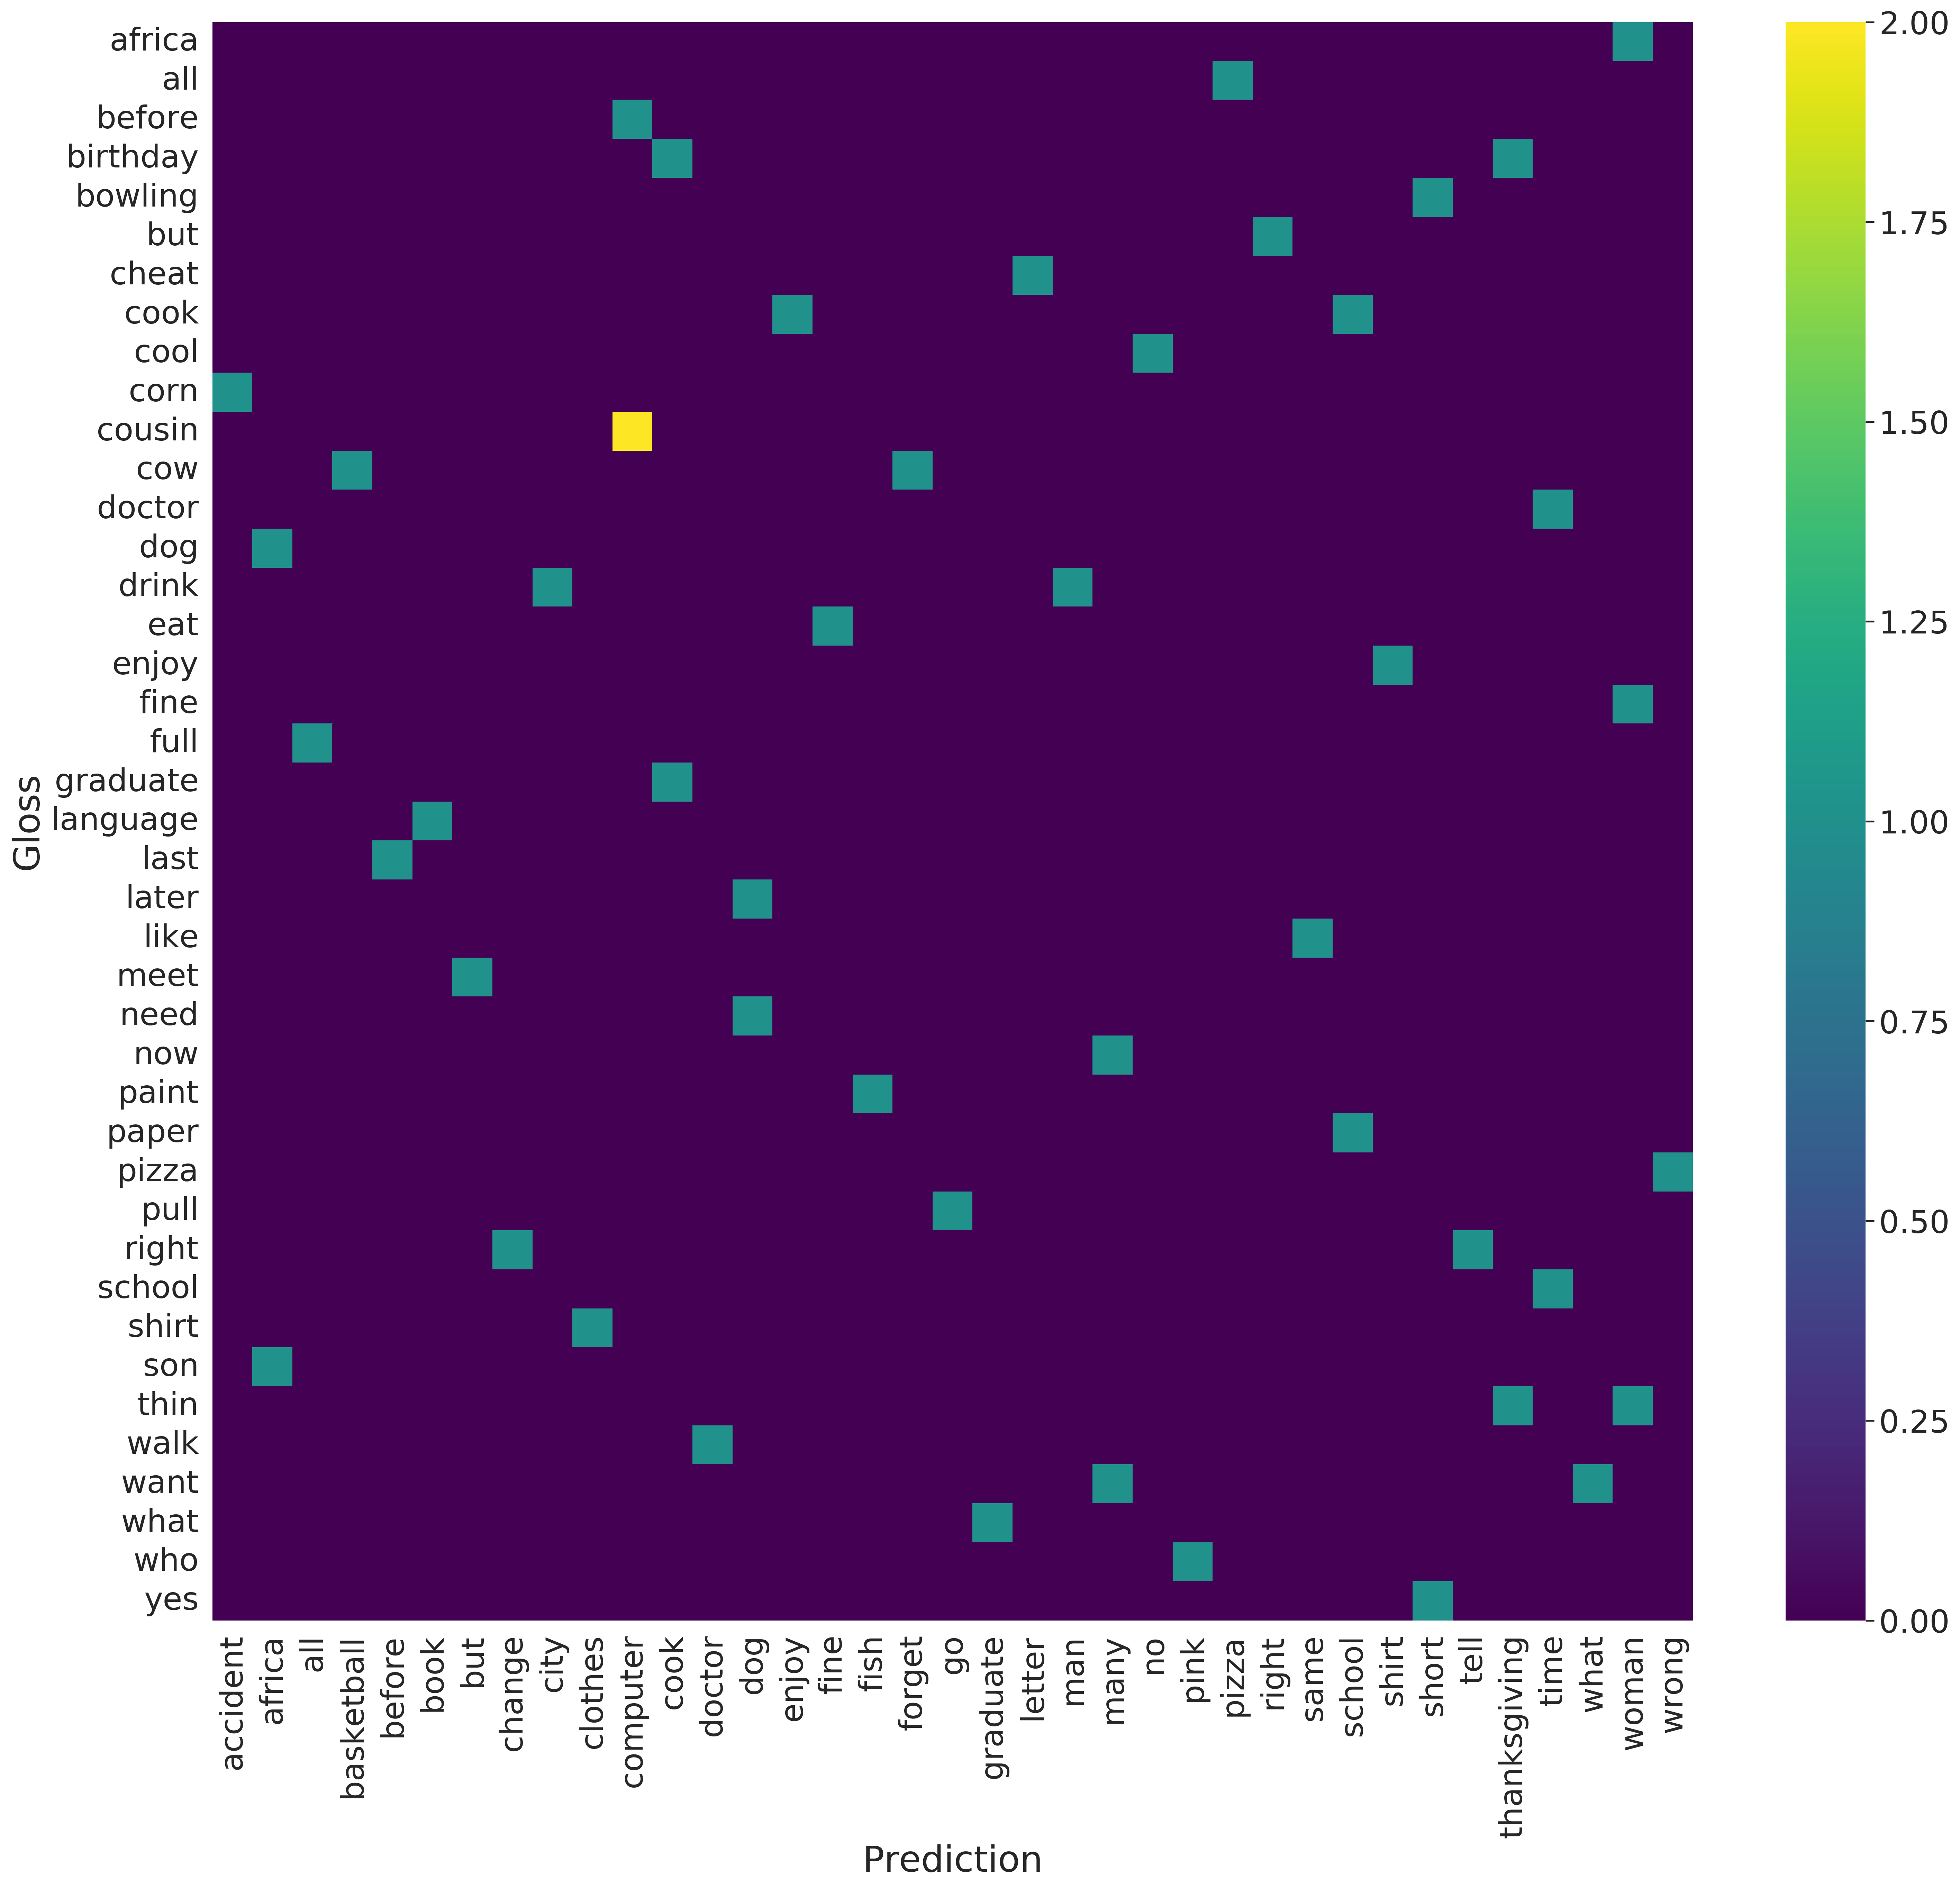

In [118]:
plt.subplots(figsize=(23,20), dpi=300)
sns.heatmap(df_confusion, cmap='viridis')
# sns.set(font_scale = 2)
plt.xlabel('Prediction', fontsize=25)
plt.ylabel('Gloss', fontsize=25)

In [112]:
class_list

{'0': 'book',
 '1': 'drink',
 '2': 'computer',
 '3': 'before',
 '4': 'chair',
 '5': 'go',
 '6': 'clothes',
 '7': 'who',
 '8': 'candy',
 '9': 'cousin',
 '10': 'deaf',
 '11': 'fine',
 '12': 'help',
 '13': 'no',
 '14': 'thin',
 '15': 'walk',
 '16': 'year',
 '17': 'yes',
 '18': 'all',
 '19': 'black',
 '20': 'cool',
 '21': 'finish',
 '22': 'hot',
 '23': 'like',
 '24': 'many',
 '25': 'mother',
 '26': 'now',
 '27': 'orange',
 '28': 'table',
 '29': 'thanksgiving',
 '30': 'what',
 '31': 'woman',
 '32': 'bed',
 '33': 'blue',
 '34': 'bowling',
 '35': 'can',
 '36': 'dog',
 '37': 'family',
 '38': 'fish',
 '39': 'graduate',
 '40': 'hat',
 '41': 'hearing',
 '42': 'kiss',
 '43': 'language',
 '44': 'later',
 '45': 'man',
 '46': 'shirt',
 '47': 'study',
 '48': 'tall',
 '49': 'white',
 '50': 'wrong',
 '51': 'accident',
 '52': 'apple',
 '53': 'bird',
 '54': 'change',
 '55': 'color',
 '56': 'corn',
 '57': 'cow',
 '58': 'dance',
 '59': 'dark',
 '60': 'doctor',
 '61': 'eat',
 '62': 'enjoy',
 '63': 'forget',


In [113]:
df

class_id  prediction_id       gloss  prediction  correct
1           5              5          go          go     True
2           1              1       drink       drink     True
3          65              3        last      before    False
4          16             16        year        year     True
5          89             89    medicine    medicine     True
..        ...            ...         ...         ...      ...
254         9              2      cousin    computer    False
255        99             99    thursday    thursday     True
256        31             31       woman       woman     True
257        77             77  basketball  basketball     True
258        86             86         how         how     True

[258 rows x 5 columns]